# Predict gene knockout strategies
This notebook is based on https://cameo.bio/05-predict-gene-knockout-strategies.html

Basically, we're trying to find out if we can optimize a certain pathway by knocking other genes in the model.
We can predict gene knockout strategies with two algorithms:
* evolutionary algorithms (OptGene) 
* linear programming (OptKnock)

In [1]:
# Load library
from cameo import load_model, fba, phenotypic_phase_plane
from cameo.strain_design import OptGene, OptKnock
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
plotter = PlotlyPlotter() # might require to install plotly

import escher
from escher import Builder

from IPython.display import IFrame

In [49]:
# custom script as cameo hasnt update its dependency with escher
def display_on_map(self, map_json, index=0, palette="YlGnBu"):
    with self._model:
        for ko in self.data_frame.loc[index, "reactions"]:
            self._model.reactions.get_by_id(ko).knock_out()
            try:
                fluxes = self._simulation_method(self._model, **self._simulation_kwargs) # for optgene
            except AttributeError:
                fluxes = fba(self._model) # for optknock
        fluxes = fba(self._model)
        builder = Builder(
            map_json = map_json,
            model = self._model,
            reaction_data = fluxes.fluxes.to_frame()
        )

    return builder

In [4]:
# load Chromobacterium model
model = load_model('../../results/iDB858_curated_phase4.xml')
model

<Model M_iDB858 at 0x1e86992e880>

In [5]:
s = fba(model)
path = "../../figures/WT_map_cycle2.html"
builder = Builder(
    map_json = "../../results/edited_map_reaction_phase4.json",
    model = model,
    reaction_data = s.fluxes.to_frame(),
    )
builder.save_html(path)
builder
#IFrame(src=path, width=700, height=600)

Builder(reaction_data=[{'rxn12008_c': 0.0023368593893455672, 'rxn00541_c': 0.0, 'ACKr': 3.552713678800501e-15,…

This showed us the fluxes in wildtype. Note that the model does not have any fluxes towards hcn production.
! [map](../figures/WT_map.html)
## Phenotypic phase plane

In [6]:
wt_solution = model.optimize()
growth = wt_solution.fluxes["biomass1.12"]
hcn_production = wt_solution.fluxes["EX_cyan_e"]

In [7]:
p = phenotypic_phase_plane(model, variables=['biomass1.12'], objective='EX_cyan_e')
p.plot(plotter, points=[(growth, hcn_production)])

The phenotypic phase plane showed us a trade off between our target (in this case acetate production) with biomass. Implying that rewiring the flux to produce acetate will deteriorate growth.

## OPTGENE

In [8]:
optgene = OptGene(model)
result = optgene.run(target=model.reactions.EX_cyan_e,
                     biomass=model.reactions.get_by_id("biomass1.12"),
                     substrate=model.metabolites.glc__D_e,
                     max_evaluations=5000,
                     population_size=1000,
                     plot=False)

Starting optimization at Wed, 20 Oct 2021 16:45:14


HBox()

Finished after 00:16:32


In [9]:
result

No solutions found


The algorithm showed the reactions or genes that can be knocked out to acquire desired target production.

In [10]:
result.plot(plotter)

KeyError: 0

The phase plane showed us how the mutant area has shifted, reducing growth in favor of producing our target.

In [11]:
path = "../../figures/MT_optgene_map_cycle2.html"
builder = display_on_map(result, "../../results/edited_map_reaction_phase4.json")
builder.save_html(path)
builder
#IFrame(src=path, width=700, height=600)

KeyError: 0

You can also compare the fluxes map with the wildtype (shown previously). You can see that now, there is a flux towards our desired target

## OPTKNOCK

In [12]:
optknock = OptKnock(model, fraction_of_optimum=0.1)

c:\users\waff\appdata\local\programs\python\python39\lib\site-packages\cameo\strain_design\deterministic\linear_programming.py:118: UserWarning:

You are trying to run OptKnock with glpk_interface. This might not end well.

c:\users\waff\appdata\local\programs\python\python39\lib\site-packages\cobra\core\group.py:107: UserWarning:

need to pass in a list



Here, I use GLPK (GNU Linear Programming Kit) as my default solver for linux. You might want to try [Gurobi](https://www.gurobi.com/) instead.


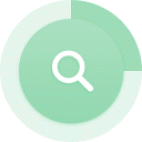

<IPython.core.display.Javascript object>

In [13]:
result = optknock.run(max_knockouts=1, target="EX_cyan_e", biomass="biomass1.12")

In [14]:
result

HBox()

In [15]:
result.plot(plotter)

In [25]:
f = result.fluxes

In [44]:
result.knockouts

[set()]

In [53]:
f[0]['rDB00166_c']

0.37686793440081295

In [50]:
path = "../../figures/MT_optknock_map_cycle2.html"
builder = display_on_map(result, "../../results/edited_map_reaction_phase4.json")
builder.save_html(path)
builder
#IFrame(src=path, width=700, height=600)

Builder(reaction_data=[{'rxn12008_c': 0.0023368593893455755, 'rxn00541_c': 0.0, 'ACKr': 0.0, 'rxn01674_c': 0.0…

In [45]:
import pickle

In [47]:
try:
    fi = open( "result_cycle2_optknock.pkl", "wb" )
    data = {
        'knockouts': result.knockouts,
        'fluxes': result.fluxes,
        'production': result.production,
        'biomass': result.biomass,
        'target': result.target,
        'data_frame': result.data_frame,
    }
    pickle.dump(data, fi)
    fi.close()
except Exception as e:
    print(e)

In [48]:
try:
    fi = open( "result_cycle2_optknock.pkl", "rb" )
    print(pickle.load(fi))
    fi.close()
except Exception as e:
    print(e)

{'knockouts': [set()], 'fluxes': [rxn12008_c    0.002284
rxn00541_c    0.000000
ACKr          0.000000
rxn01674_c    0.000000
rxn00802_c    0.064496
                ...   
rDB00181_c    0.000000
rDB00182_c    0.000000
EX_acn_e     -0.000000
EX_cyan_e     0.107999
CYANt         0.107999
Name: fluxes, Length: 914, dtype: float64], 'production': [0.10799867614791803], 'biomass': [0.2459132558219608], 'target': 'EX_cyan_e', 'data_frame':   reactions size  EX_cyan_e   biomass  fva_min   fva_max
0        {}    0   0.107999  0.245913      0.0  0.047785}
